In [1]:
%matplotlib widget
# -*- coding: utf-8 -*-
"""
@author: Pierre Guiot
Adaptation en notebook: Raphaël Wicker, Cateline Lantz
"""

'\n@author: Pierre Guiot\nAdaptation en notebook: Raphaël Wicker, Cateline Lantz\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import glob
from astropy.io import fits # Pour ouvrir et manipuler les données
from scipy.ndimage import rotate # Pour la rotation des images
from scipy.optimize import curve_fit # Pour la régression linéaire

# Lecture des données

Les prochaines lignes permettent d'accéder aux images de science, de Dark, de calib et potentiellement de Flats, pour les lire et récupérer les données sous forme d'array numpy.

Les chemins doivent prendre la forme `chemin/vers/les/fichiers/*`, l'astérique servant à signifier que vous récupérez tous les fichiers à l'intérieur du dossier qui vous intéresse.

### Code

In [17]:
science_path = " " # Chemin vers les données de science
dark_path = " " # Chemin vers les dark
calib_path = " " # Chemin vers les calibs
# Si utilisation des flats, rajouter le chemin

science_cube = []
dark_cube = []
calib_cube = []


for i, file in enumerate(sorted(glob.glob(science_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    science_cube.append(image)

science_cube = np.asarray(science_cube)

for i, file in enumerate(sorted(glob.glob(dark_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    dark_cube.append(image)

dark_cube = np.asarray(dark_cube)

for i, file in enumerate(sorted(glob.glob(calib_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    calib_cube.append(image)

calib_cube = np.asarray(calib_cube)
# Si utilisation des flats, créer un flat_cube sur le modèle des blocs de code précédents

### Visualisation

Afin d'améliorer la visualisation des contrastes des images, vous pourrez spécifier des mots-clef `vmin` et `vmax` à l'intérieur des `plt.imshow()`.
Sans spécifier ces seuils vous risquez de vous retrouver avec des images entièrement blanches, noires, ou saturées.

<IPython.core.display.Javascript object>


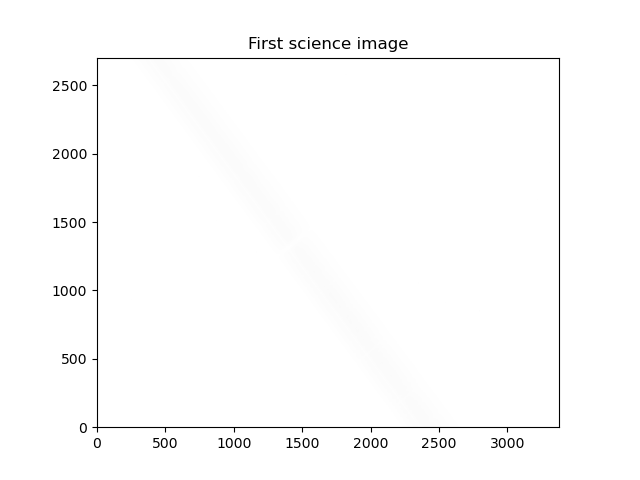

<IPython.core.display.Javascript object>


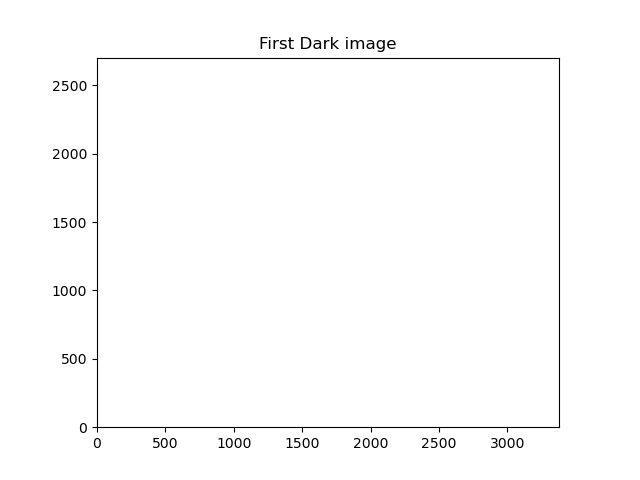

<IPython.core.display.Javascript object>


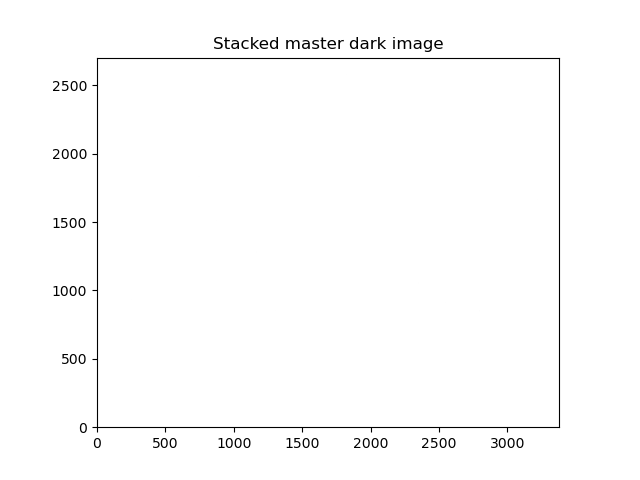

<IPython.core.display.Javascript object>


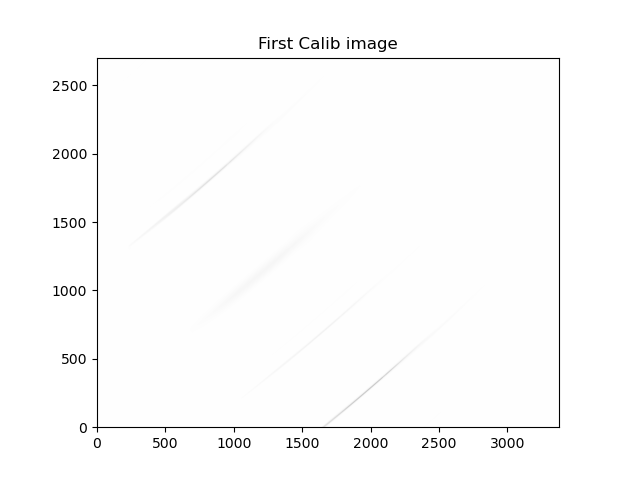

<IPython.core.display.Javascript object>


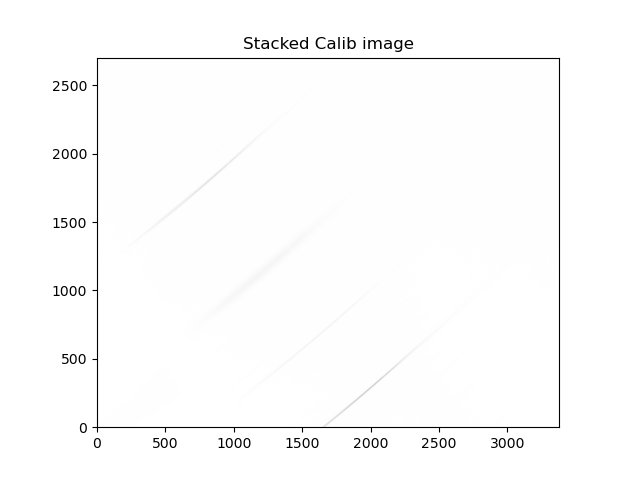

Text(0.5, 1.0, 'Stacked Calib image')

In [18]:
plt.figure(1)
plt.clf()
plt.imshow(science_cube[0], interpolation=None, origin='lower', cmap='Greys') #vmin = , vmax = 
plt.title('First science image')

plt.figure(2)
plt.clf()
plt.imshow(dark_cube[0], interpolation=None, origin='lower', cmap='Greys')
plt.title('First Dark image')

plt.figure(3)
plt.clf()
plt.imshow(np.mean(dark_cube, axis=0), interpolation=None, origin='lower', cmap='Greys')
plt.title('Stacked master dark image')

plt.figure(4)
plt.clf()
plt.imshow(calib_cube[0], interpolation=None, origin='lower', cmap='Greys')
plt.title('First Calib image')

plt.figure(5)
plt.clf()
plt.imshow(np.mean(calib_cube, axis=0), interpolation=None, origin='lower', cmap='Greys')
plt.title('Stacked Calib image')

# Si utilisation des flats, les visualiser sur le modèle des blocs de code précédents

# Réduction des données

Dans cette section, le but est de réduire les données brutes de science, pour parvenir à des données exploitables scientifiquement. Une image réduite $I_r$ est la soustraction de l'image brute $I_r$ et de la moyenne des darks, ou Master Dark, MD : $I_t = I_b - MD$. En cas d'utilisation des Flats, il faut également diviser le tout par la moyenne des Flats, le Master Flat MF : $I_r = \frac{I_b - MD}{MF}$.

### Code

In [19]:
for i in range(science_cube.shape[0]):
    science_cube[i,:,:] = science_cube[i,:,:] - np.mean(dark_cube, axis=0) #Ajouter le master flat si nécessaire

### Visualisation

<IPython.core.display.Javascript object>


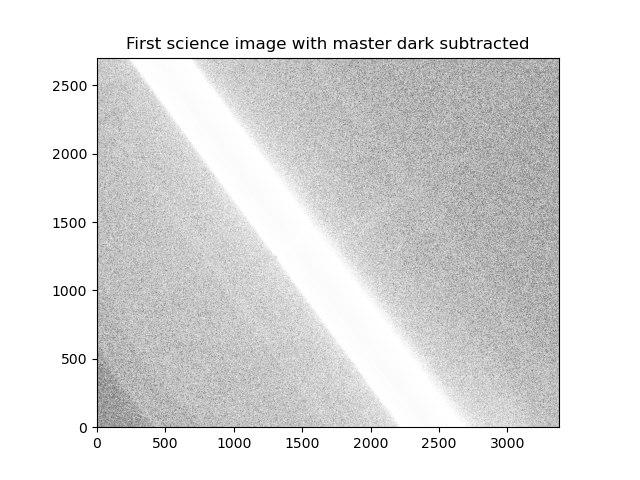

Text(0.5, 1.0, 'First science image with master dark subtracted')

In [20]:
plt.figure(6)
plt.clf()
plt.imshow(science_cube[0,:,:], interpolation=None, origin='lower', cmap='Greys') #vmin = , vmax = 
plt.title('First science image with master dark subtracted')

# Rotation des spectres

Le plus souvent, les spectres que vous obtiendrez en sortie de la réduction seront inclinés. Etant donné que votre but sera d'analyser des spectres, cela sera plus simple s'il suffit de récupérer une ligne dans un tableau numpy pour faire ce travail. Il faudra donc faire tourner l'image selon un angle que vous aurez déterminé pour que le spectre soit horizontal.

Pour pouvoir étalonner facilement les spectres, il faut faire cette démarche avec l'image de calibration également.

### Code

In [21]:
### Données de science ###

rotated_cube = [] 
rotation_angle = # A déterminer à l'aide de DS9
for i in range(science_cube.shape[0]):
    rotated_cube.append(rotate(science_cube[i,:,:], rotation_angle))
rotated_cube = np.asarray(rotated_cube)

### Images de calibration ###

image = calib_cube[0,:,:]

pixel_cut = # A modifier
ar_ne_spectrum = rotate(image,rotation_angle)[pixel_cut,:]

### Visualisation

<IPython.core.display.Javascript object>


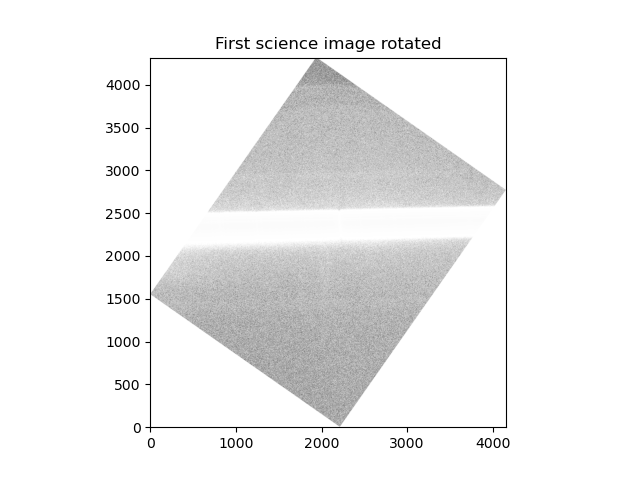

<IPython.core.display.Javascript object>


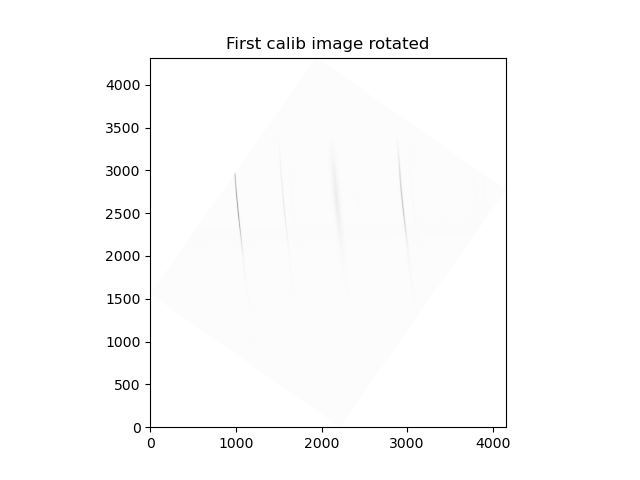

<IPython.core.display.Javascript object>


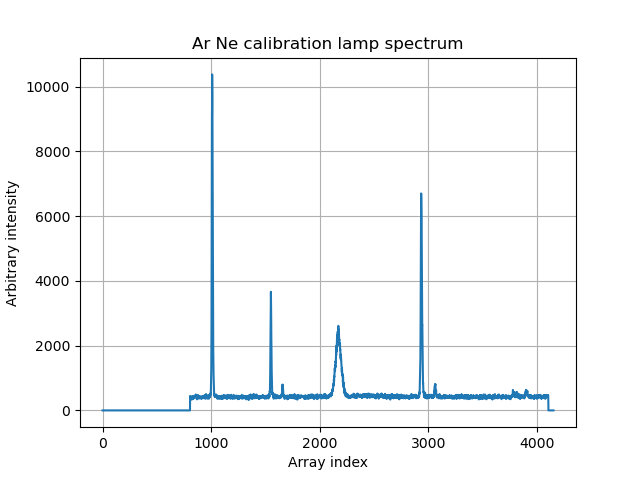

In [22]:
### Données de science ###

plt.figure(7)
plt.clf()
plt.imshow(rotated_cube[0,:,:], interpolation=None, origin='lower', cmap='Greys') #vmin = ,  vmax =
plt.title('First science image rotated')

### Images de calibration ###

plt.figure(8)
plt.clf()
plt.imshow(rotate(image,rotation_angle), interpolation=None, origin='lower', cmap='Greys') #vmin = ,  vmax =
plt.title('First calib image rotated')

plt.figure(9)
plt.clf()
plt.plot(ar_ne_spectrum)
plt.xlabel('Array index')
plt.ylabel('Arbitrary intensity')
plt.title('Ar Ne calibration lamp spectrum')
plt.grid()

# Etalonnage spectral à l'aide la lampe ArNe

Dans cette section, le but sera d'étalonner votre spectre, en reliant les positions des pics en pixels aux longueurs d'onde correspondantes.

### Définition de la zone du spectre

<IPython.core.display.Javascript object>


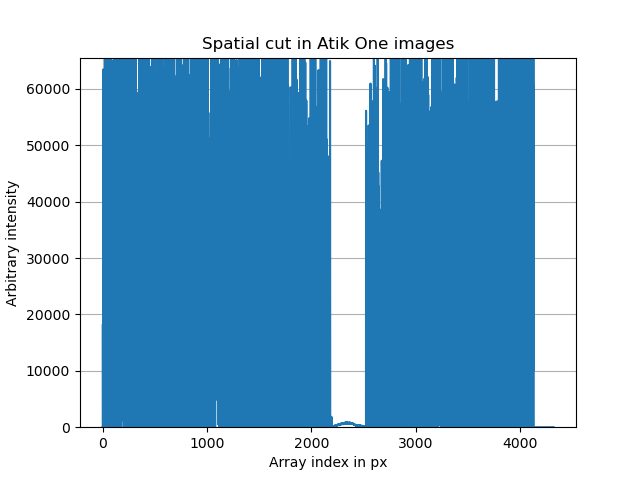

<IPython.core.display.Javascript object>


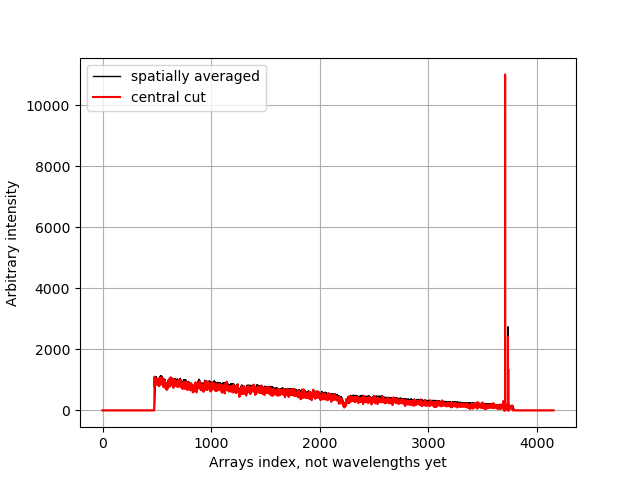

In [25]:
plt.figure(10)
plt.clf()
plt.plot(rotated_cube[0,:,2210]) # À modifier
plt.ylim(0,1000) # À modifier
plt.ylabel('Arbitrary intensity')
plt.xlabel('Array index in px')
plt.grid()
plt.title('Spatial cut in Atik One images')


avg_pixels= # À modifier
extract_avg_spectrum = np.mean(rotated_cube[0,avg_pixels:avg_pixels+20,:], axis=0)


central_pix= # À modifier
plt.figure(11)
plt.clf()
plt.plot(extract_avg_spectrum, 'k-', lw=1, label='spatially averaged')
plt.plot(rotated_cube[0,central_pix,:], 'r-', label='central cut')
plt.ylabel('Arbitrary intensity')
plt.xlabel('Arrays index, not wavelengths yet')
plt.title(' ') # À modifier
plt.grid()
plt.ylim()
plt.legend(loc='best')

### Correspondance pixels/longueurs d'onde

In [26]:
pixels_peaks = np.array([ ]) # A remplir
peaks_lambda = np.array([ ]) # A remplir
def affine(x, a=1, b=1):
    return a*x + b

calib_wvl = curve_fit(affine, pixels_peaks, peaks_lambda, p0=[2, 50])

calib_wavelengths = affine(range(len(extract_avg_spectrum)), a=calib_wvl[0][0], b=calib_wvl[0][1])

### Visualisation des spectres étalonnés

<IPython.core.display.Javascript object>


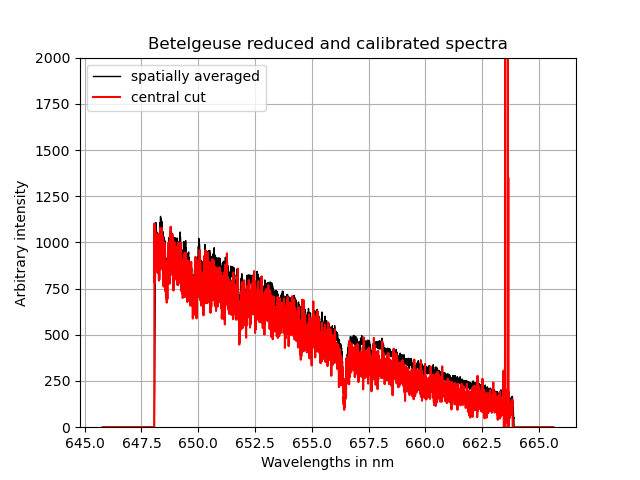

Traitement terminé, place à l'analyse !


In [27]:
plt.figure(12)
plt.clf()
plt.plot(calib_wavelengths, extract_avg_spectrum, 'k-', lw=1, label='spatially averaged')
plt.plot(calib_wavelengths, rotated_cube[0,central_pix,:], 'r-', label='central cut')
plt.ylabel('Arbitrary intensity')
plt.xlabel('Wavelengths in nm')
plt.title('Reduced and calibrated spectra')
plt.grid()
plt.legend(loc='best')
plt.ylim(0, 2000) # A modifier


print("Traitement terminé, place à l'analyse !")